In [1]:
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization,Softmax,Dropout
from keras.layers import Conv2D,MaxPool2D
from keras.models import Model,Input
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Nadam

In [2]:
def _parse_function(example_proto):
    features = {'label':tf.FixedLenFeature([], tf.int64),
              'img_raw':tf.FixedLenFeature([], tf.string)}
    parsed_features = tf.parse_single_example(example_proto, features)
    img = tf.decode_raw(parsed_features['img_raw'], tf.uint8)
    img = tf.reshape(img, [120, 120, 3])
    label = tf.cast(parsed_features['label'], tf.int32)
    return img, label

In [3]:
imgs=[]
labels=[]
filenames = ["train.tfrecords","test.tfrecords"]
dataset = tf.data.TFRecordDataset(filenames)
dataset = dataset.map(_parse_function)
iterator = iter(dataset)
try:
    while True:
        img=iterator.get_next()[0]
        label=iterator.get_next()[1]
        imgs.append(img)
        labels.append(label)
except tf.errors.OutOfRangeError:
    print('Done')

Done


In [4]:
imgs=np.array(imgs)
labels=np.array(labels)

In [5]:
imgs.shape,labels.shape

((949, 120, 120, 3), (949,))

In [6]:
label_str={0:'bicycle',1:'car',2:'motorbike',3:'trucks'}

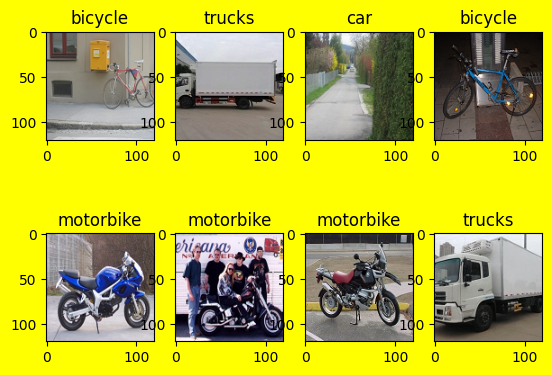

In [7]:
figure=plt.figure()
figure.set_facecolor('yellow')
for i in range(8):
    index=np.random.randint(imgs.shape[0],size=1)[0]
    ax=figure.add_subplot(241+i)
    ax.set_title(label_str[labels[index]])
    ax.imshow(imgs[index])
plt.show()

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_test, Y_train, Y_test =train_test_split(imgs,labels,test_size=0.2, random_state=0)

In [9]:
y_train=np_utils.to_categorical(Y_train)
y_test=np_utils.to_categorical(Y_test)

In [10]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((759, 120, 120, 3), (190, 120, 120, 3), (759, 4), (190, 4))

In [11]:
def net(input_x):
    x=Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),padding='valid')(input_x)
    x=Activation('relu')(x)
    x=MaxPool2D(pool_size=(3,3),strides=(2,2),padding='valid')(x)
    x=BatchNormalization()(x)
    x=Conv2D(filters=64,kernel_size=(5,5),strides=(1,1),padding='same')(x)
    x=MaxPool2D(pool_size=(3,3),strides=(2,2))(x)
    x=Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='same')(x)
    x=MaxPool2D(pool_size=(3,3),strides=(2,2))(x)
    x=Flatten()(x)
    x=Activation('relu')(x)
    x=Dense(4)(x)
    y=Softmax()(x)

    return Model([input_x], [y])

In [12]:
input_X=Input((120,120,3))
model=net(input_X)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 96)        34944     
_________________________________________________________________
activation (Activation)      (None, 28, 28, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 13, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        153664    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0     

In [13]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

checkpoint = ModelCheckpoint("ep{epoch:03d}-loss{loss:.3f}-val_accuracy{val_accuracy:.3f}.h5",
                             monitor='val_accuracy',save_weights_only=True, save_best_only=True, period=1)
# plot_model(model, to_file="net.png",show_shapes=True)
history=model.fit(X_train,y_train,validation_split=0.2,epochs=50,batch_size=128,callbacks=[checkpoint],shuffle=True)

Epoch 1/50
5/5 [==============================] - 6s 1s/step - loss: 1.4841 - accuracy: 0.4563 - val_loss: 11.5768 - val_accuracy: 0.2961
Epoch 2/50
5/5 [==============================] - 5s 971ms/step - loss: 0.9074 - accuracy: 0.6409 - val_loss: 17.8872 - val_accuracy: 0.3092
Epoch 3/50
5/5 [==============================] - 5s 967ms/step - loss: 0.6922 - accuracy: 0.7199 - val_loss: 4.8210 - val_accuracy: 0.3882
Epoch 4/50
5/5 [==============================] - 5s 921ms/step - loss: 0.5136 - accuracy: 0.8072 - val_loss: 5.1137 - val_accuracy: 0.4276
Epoch 5/50
5/5 [==============================] - 5s 956ms/step - loss: 0.3825 - accuracy: 0.8830 - val_loss: 3.4303 - val_accuracy: 0.4803
Epoch 6/50
5/5 [==============================] - 5s 962ms/step - loss: 0.2799 - accuracy: 0.9094 - val_loss: 2.3677 - val_accuracy: 0.5329
Epoch 7/50
5/5 [==============================] - 5s 934ms/step - loss: 0.2097 - accuracy: 0.9407 - val_loss: 1.6491 - val_accuracy: 0.6316
Epoch 8/50
5/5 [=====

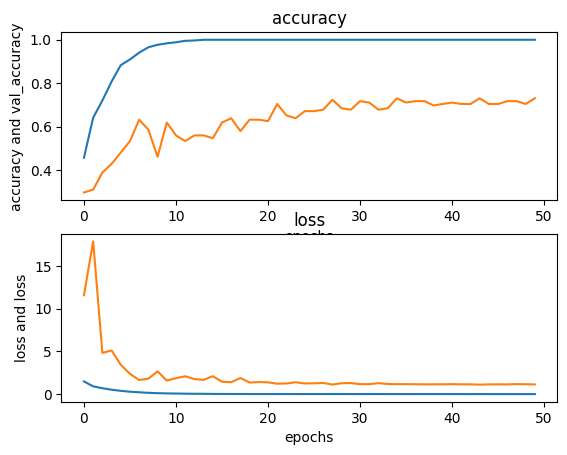

In [14]:
accuracy=history.history['accuracy']
val_accuracy=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

figure=plt.figure()
ax1=figure.add_subplot(211)
ax1.set(title="accuracy", xlabel='epochs', ylabel='accuracy and val_accuracy')
ax1.plot(accuracy)
ax1.plot(val_accuracy)

ax2=figure.add_subplot(212)
ax2.set(title="loss", xlabel='epochs', ylabel='loss and loss')
ax2.plot(loss)
ax2.plot(val_loss)
plt.show()

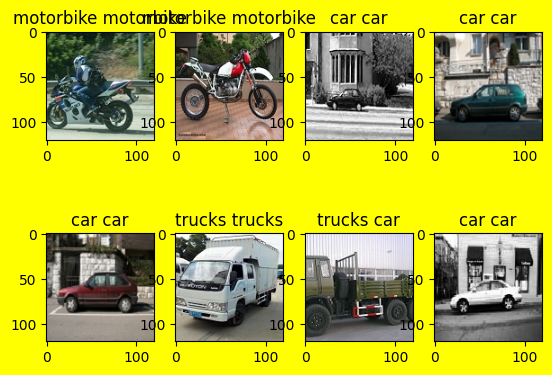

In [15]:
figure=plt.figure()
figure.set_facecolor('yellow')
for i in range(8):
    index=np.random.randint(X_test.shape[0],size=1)[0]
    test=np.array([X_test[index]])
    pre=model.predict(test)
    ax=figure.add_subplot(241+i)
    ax.set_title(label_str[Y_test[index]]+' '+label_str[list(pre[0]).index(max(pre[0]))])
    ax.imshow(X_test[index])
plt.show()

In [16]:
from keras import models
from keras import backend as K

In [22]:
X_test.shape

(190, 120, 120, 3)

In [89]:
# input_iamges=np.zeros=((10,120,120,3))
layer_1=K.function([model.layers[0].input],[model.layers[1].output])

In [90]:
index=np.random.randint(X_test.shape[0],size=1)[0]
f1=layer_1([X_test])[0]
index,f1.shape

(153, (190, 28, 28, 96))

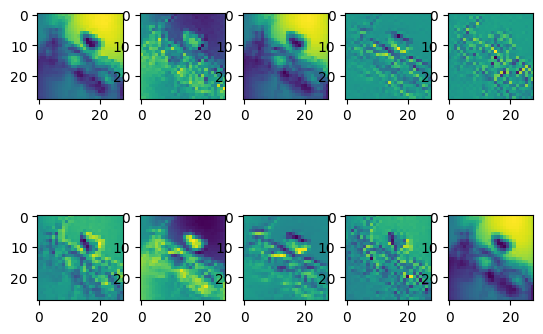

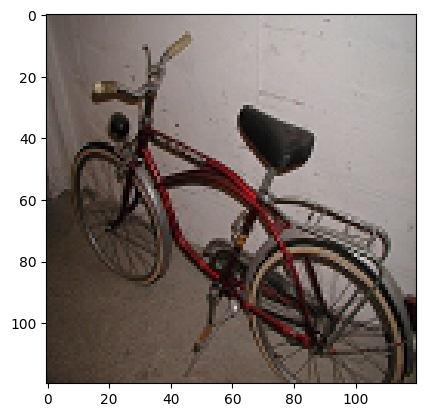

In [91]:
plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(f1[index,:,:,i], cmap='viridis')
plt.show()

plt.imshow(X_test[index])
plt.show()